In [1]:
%autosave 0
import numpy as np
import pandas as pd

from sklearn.linear_model import ElasticNet
from sklearn.model_selection import cross_val_score
from sklearn.metrics import r2_score as r2
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objs as go
import plotly.express as px

from datetime import date, timedelta
from joblib import dump

import warnings
warnings.filterwarnings("ignore") 

Autosave disabled


Start Day : 28/03

Trying to predict number of new cases & deaths one day before

Working with data update everyday here : https://ourworldindata.org/coronavirus-source-data
I take the full dataset linked

In [2]:
## Today Data scrap on nb 00 
df = pd.read_csv(f"AzureSC/Base_Files/full_data{date.today()}.csv")

In [3]:
df.head(3)

,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,...,gdp_per_capita,extreme_poverty,cardiovasc_death_rate,diabetes_prevalence,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index
0,ABW,North America,Aruba,2020-03-13,2.0,2.0,NaN,0.0,0.0,NaN,...,35973.781,NaN,NaN,11.62,NaN,NaN,NaN,NaN,76.29,NaN
1,ABW,North America,Aruba,2020-03-19,NaN,NaN,0.286,NaN,NaN,0.0,...,35973.781,NaN,NaN,11.62,NaN,NaN,NaN,NaN,76.29,NaN
2,ABW,North America,Aruba,2020-03-20,4.0,2.0,0.286,0.0,0.0,0.0,...,35973.781,NaN,NaN,11.62,NaN,NaN,NaN,NaN,76.29,NaN


In [4]:
df.tail(3)

,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,...,gdp_per_capita,extreme_poverty,cardiovasc_death_rate,diabetes_prevalence,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index
47535,NaN,NaN,International,2020-09-30,696.0,NaN,NaN,7.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
47536,NaN,NaN,International,2020-10-01,696.0,NaN,NaN,7.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
47537,NaN,NaN,International,2020-10-02,696.0,NaN,NaN,7.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
df['location'].unique()

array(['Aruba', 'Afghanistan', 'Angola', 'Anguilla', 'Albania', 'Andorra',
       'United Arab Emirates', 'Argentina', 'Armenia',
       'Antigua and Barbuda', 'Australia', 'Austria', 'Azerbaijan',
       'Burundi', 'Belgium', 'Benin', 'Bonaire Sint Eustatius and Saba',
       'Burkina Faso', 'Bangladesh', 'Bulgaria', 'Bahrain', 'Bahamas',
       'Bosnia and Herzegovina', 'Belarus', 'Belize', 'Bermuda',
       'Bolivia', 'Brazil', 'Barbados', 'Brunei', 'Bhutan', 'Botswana',
       'Central African Republic', 'Canada', 'Switzerland', 'Chile',
       'China', "Cote d'Ivoire", 'Cameroon',
       'Democratic Republic of Congo', 'Congo', 'Colombia', 'Comoros',
       'Cape Verde', 'Costa Rica', 'Cuba', 'Curacao', 'Cayman Islands',
       'Cyprus', 'Czech Republic', 'Germany', 'Djibouti', 'Dominica',
       'Denmark', 'Dominican Republic', 'Algeria', 'Ecuador', 'Egypt',
       'Eritrea', 'Western Sahara', 'Spain', 'Estonia', 'Ethiopia',
       'Finland', 'Fiji', 'Falkland Islands', 'France',

# Data Exploration

In [6]:
def massBalance(subject,df,country):
    """ Plot evolution of data by columns
    params :
        subject = name of cols concerned by the plot
        df = The Dataframe
        country = Name of location isolated for the plot
    """
    df = df[df['location'].isin([f"{country}"])]
    df = df.iloc[::-1]
    thisPlot = px.line(x=df["date"], y=df[f"{subject}"])
    thisPlot.update_layout(title=f"Covid {subject} {country}",
                           xaxis_title="Day",
                           yaxis_title="Volume",
                           font=dict(family="Courier New, monospace",size=18, color="#78281F"))
    thisPlot.show()

In [7]:
## Plotly graph will be not display on Git ##
# massBalance("total_deaths",df,"World")
# massBalance("total_deaths",df,"France")
# massBalance("total_deaths",df,"China")
# massBalance("total_deaths",df,"Italy")
# massBalance("total_deaths",df,"Spain")
# massBalance("total_deaths",df,"United States")
# massBalance("total_deaths",df,"Germany")
# massBalance("total_deaths",df,"Iran")
# massBalance("total_deaths",df,"Turkey")
# massBalance("total_deaths",df,"Brazil")

In [8]:
## Plotly graph will be not display on Git ##
# massBalance("total_cases",df,"World")
# massBalance("total_cases",df,"France")
# massBalance("total_cases",df,"China")
# massBalance("total_cases",df,"Italy")
# massBalance("total_cases",df,"Spain")
# massBalance("total_cases",df,"United States")
# massBalance("total_cases",df,"United Kingdom")
# massBalance("total_cases",df,"Germany")
# massBalance("total_cases",df,"Iran")
# massBalance("total_cases",df,"Turkey")
# massBalance("total_cases",df,"Brazil")

In [9]:
def newOverTime(subject,df,country):
    df = df[df['location'].isin([f"{country}"])]
    df = df.iloc[::-1]
    thisPlot = px.bar(df, x=df["date"], y=df[f'{subject}'])
    thisPlot.update_layout(title=f"Covid {subject} {country}",
                           xaxis_title="Day",
                           yaxis_title="Volume",
                           font=dict(family="Courier New, monospace",size=18, color="#78281F"))
    thisPlot.show()

In [10]:
## Plotly graph will be not display on Git ##
# newOverTime("new_cases",df,"World")
# newOverTime("new_cases",df,"France")
# newOverTime("new_cases",df,"China")
# newOverTime("new_cases",df,"Italy")
# newOverTime("new_cases",df,"Spain")
# newOverTime("new_cases",df,"United States")
# newOverTime("new_cases",df,"United Kingdom")
# newOverTime("new_cases",df,"Germany")
# newOverTime("new_cases",df,"Iran")
# newOverTime("new_cases",df,"Turkey")
# newOverTime("new_cases",df,"Brazil")

In [11]:
## Plotly graph will be not display on Git ##
# newOverTime("new_deaths",df,"World")
# newOverTime("new_deaths",df,"France")
# newOverTime("new_deaths",df,"China")
# newOverTime("new_deaths",df,"Italy")
# newOverTime("new_deaths",df,"Spain")
# newOverTime("new_deaths",df,"United States")
# newOverTime("new_deaths",df,"United Kingdom")
# newOverTime("new_deaths",df,"Germany")
# newOverTime("new_deaths",df,"Iran")
# newOverTime("new_deaths",df,"Turkey")
# newOverTime("new_deaths",df,"Brazil")

In [12]:
def worldrep(subject,graph_long=5,val_larg=1000000,df=df):
    fidf_mod = df.sort_values(subject, axis=0, ascending =False).head(500)
    f, ax = plt.subplots(figsize=(15, graph_long))

    ax.set(xlim=(0, val_larg), 
           ylabel= "Pays",
           xlabel= subject,
           Title= (f"{subject} by country")
          )
    ax.legend()
    sns.despine(top=True)
    ax = sns.barplot(x=fidf_mod[subject], y=fidf_mod["location"])


No handles with labels found to put in legend.


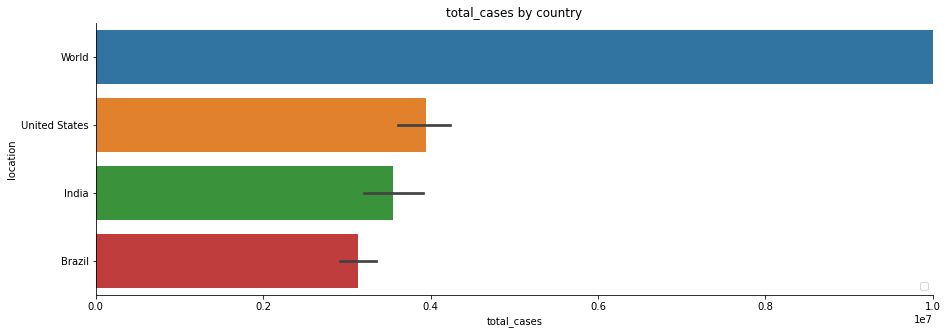

In [13]:
worldrep("total_cases",graph_long=5,val_larg=10000000)

No handles with labels found to put in legend.


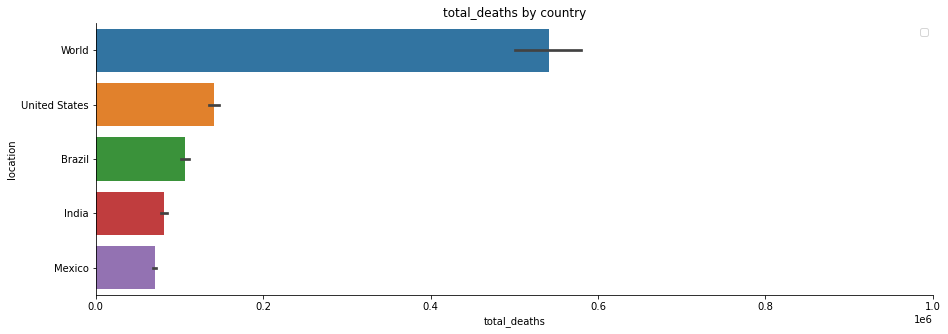

In [14]:
worldrep("total_deaths",val_larg=1000000)

In [15]:
dds = df[df["date"].isin([f'{date.today()}'])]

No handles with labels found to put in legend.


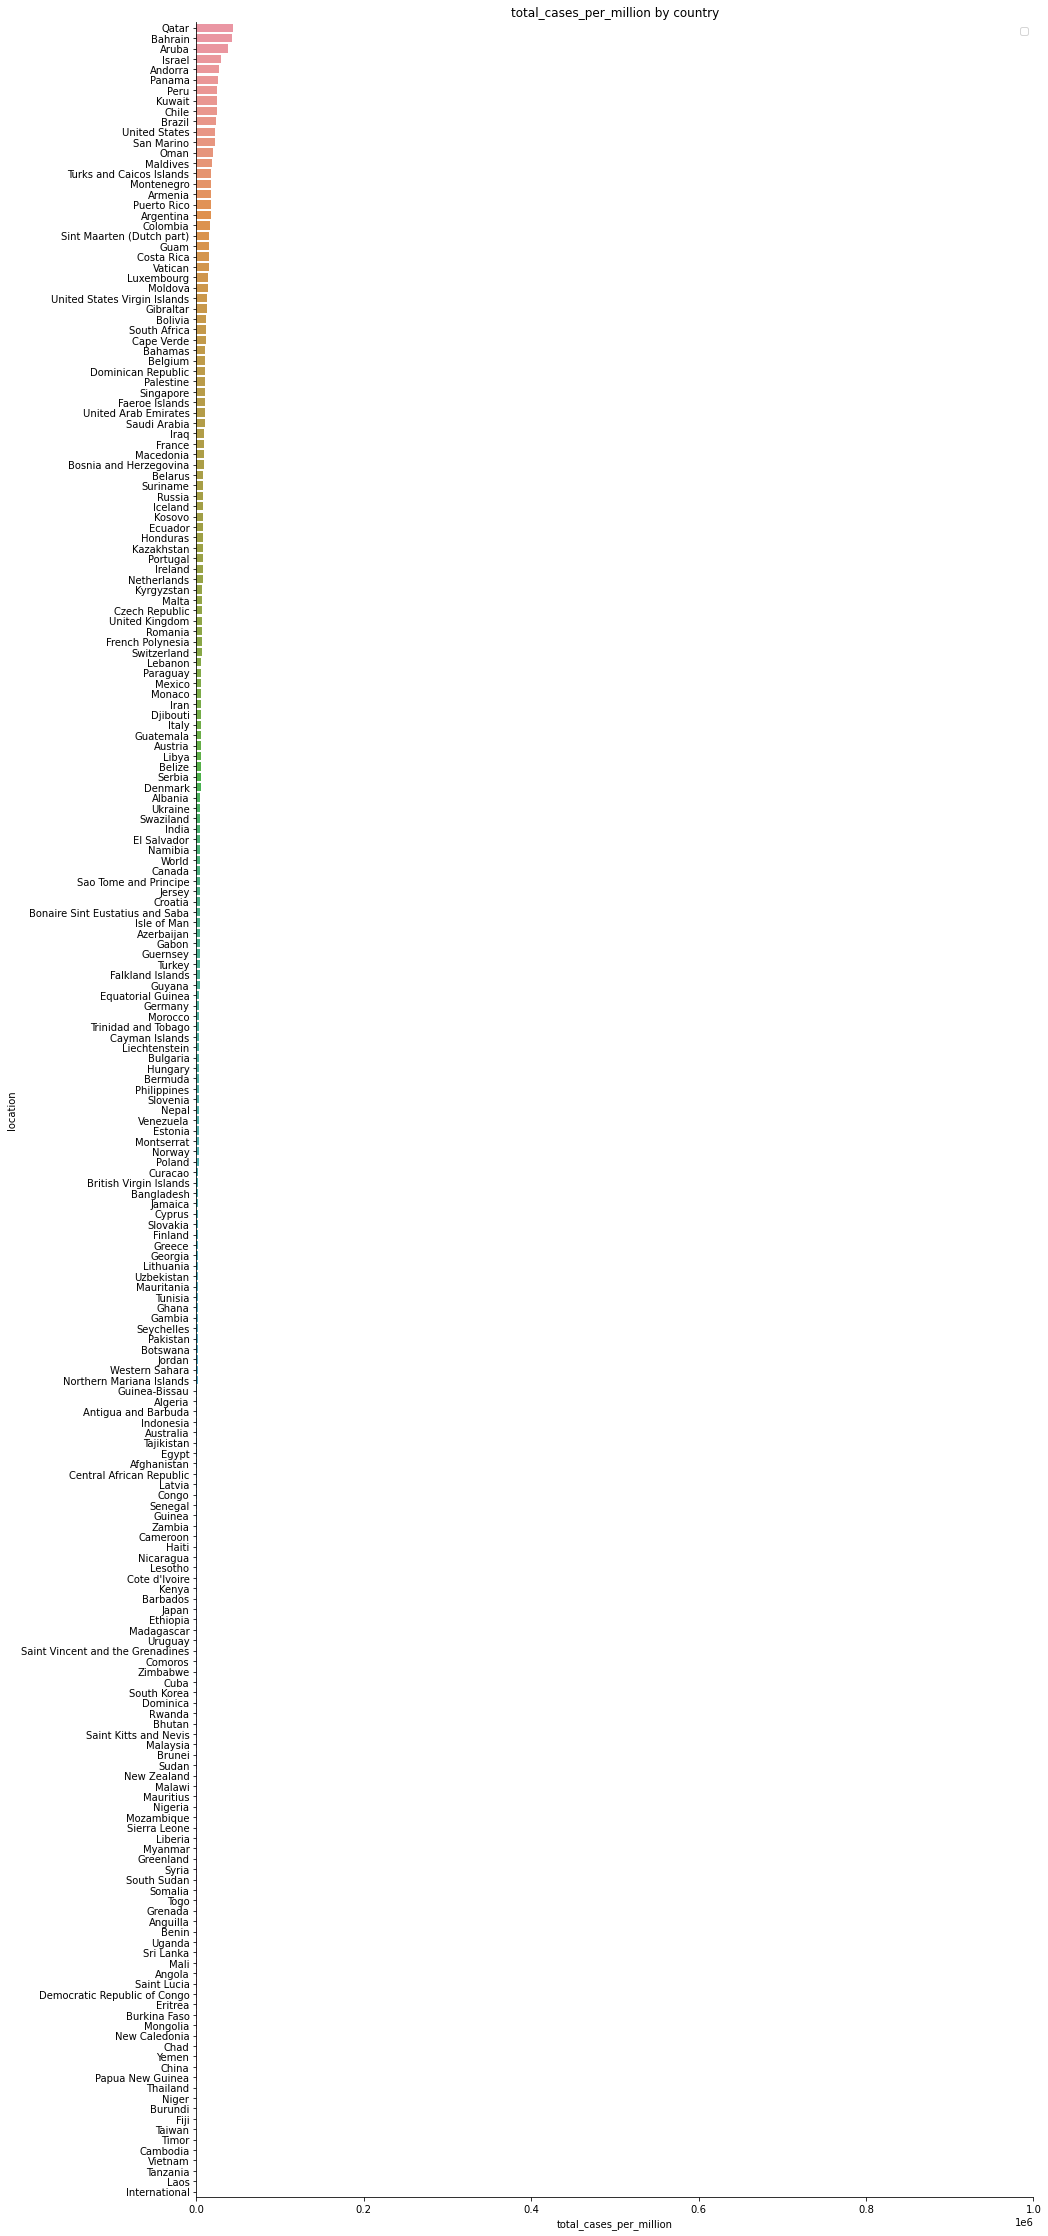

In [16]:
try:
    worldrep("total_cases_per_million",graph_long=40,val_larg=1000000,df=dds)
except:
    print("Not today")

No handles with labels found to put in legend.


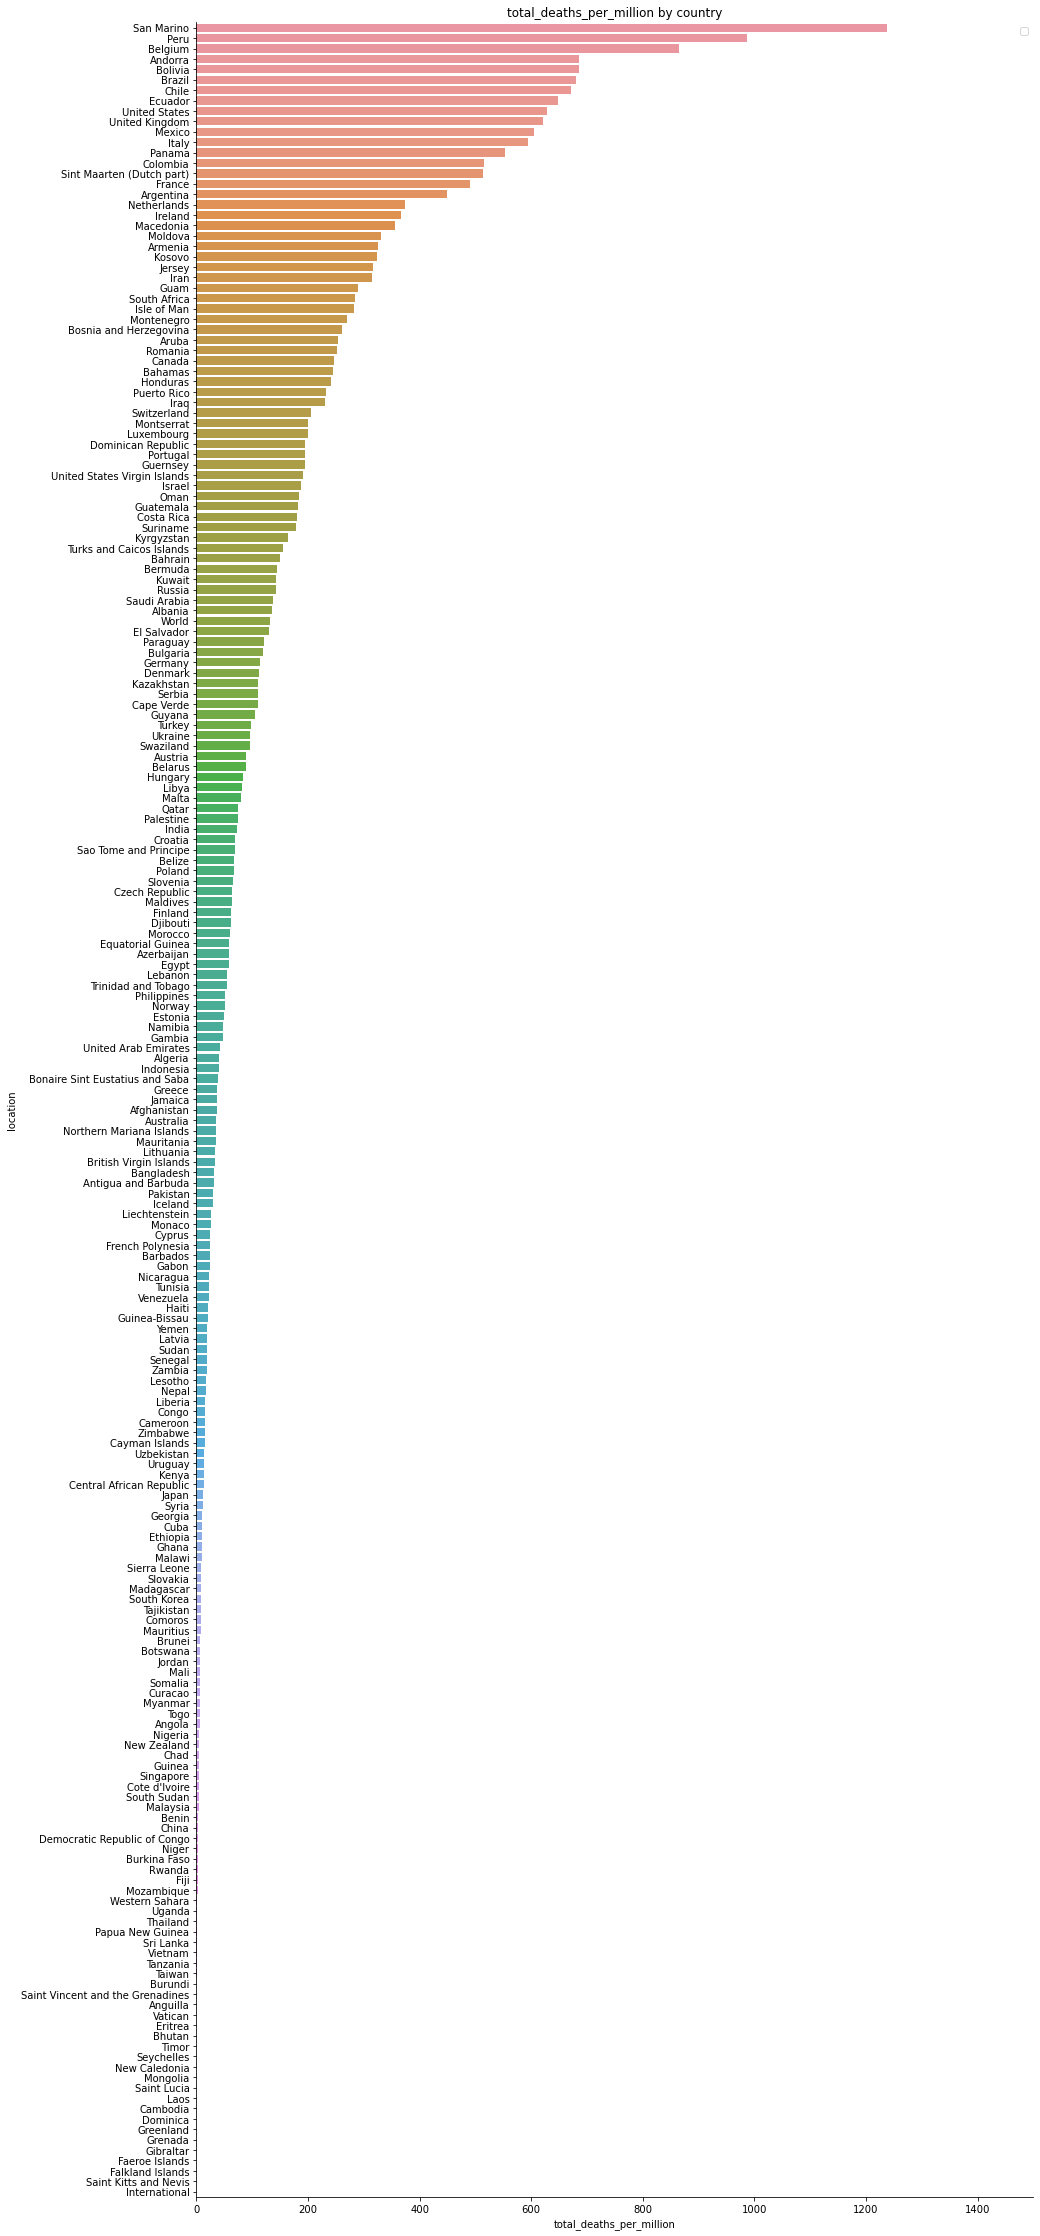

In [17]:
try :
    worldrep("total_deaths_per_million",graph_long=40,val_larg=1500,df=dds)
    is_full_data = True
except:
    is_full_data = False
    print("not today")

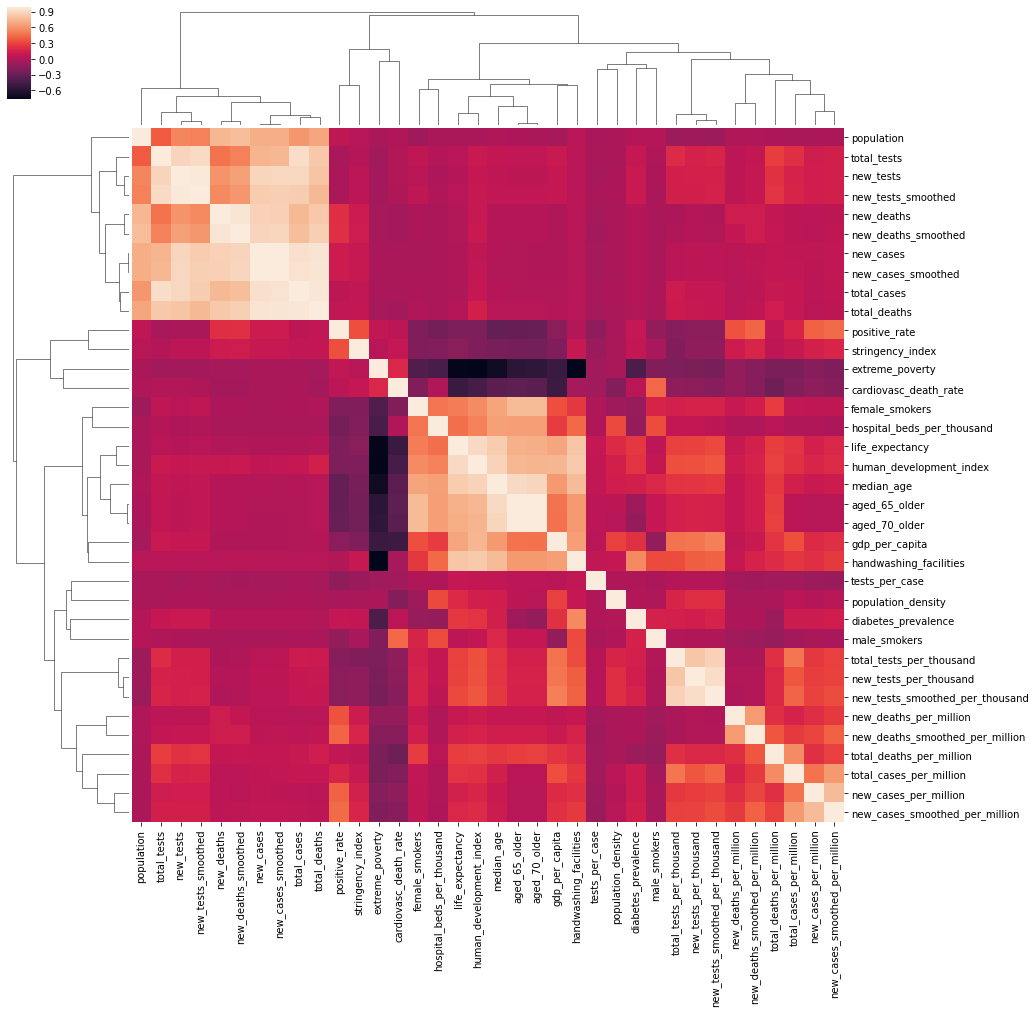

In [18]:
if is_full_data:
    corr = df.corr()
    sns.clustermap(corr,figsize=(15, 15))
else :
    print("not today")

# Modeling routines

In [19]:
def createModel(subject,periode,country,n_splits=3,max_iter=5000):
    
    df = pd.read_csv(f"AzureSC\\Base_Files\\full_data{date.today()}.csv")
    df = df[df['location'].isin([f"{country}"])] 
    vals = df[[f"{subject}"]].values
    
    imp = SimpleImputer(missing_values=np.nan, strategy='constant')
    vals = imp.fit_transform(vals)
    
    hisShape = vals.shape[0]
    x_train = []
    y_train = []

    for i in range(periode,hisShape):
        x_train.append(vals[(i-periode):i,0]) 
        y_train.append(vals[i,0])

    x_train = np.array(x_train) 
    y_train = np.array(y_train)
    
    ###############################################################
    model = ElasticNet(random_state=0,max_iter=max_iter) 
    # tol=0.01 by reducing this hp warning disapear, pred will be highter 
    ###############################################################
    
    tscv = TimeSeriesSplit(n_splits=n_splits)
    scores = cross_val_score(model, x_train, y_train, cv=tscv)
    print(f"R^2: {scores.mean()} (+/- {scores.std()})")
    
    model.fit(x_train,y_train)
    print("Coef : ",model.coef_)
    
    return vals, x_train,y_train, model

In [20]:
def predicTomorow(vals,model,periode):
    tmw = vals[-periode:]
    lili = []
    for i in tmw:
        lili.append(int(i))
    lili = np.array(lili).reshape(1, -1) 
    res = int(model.predict(lili))
    last_day = lili[0][periode-1]
    diff_betw = res-last_day
    print(f"{periode} Last_days : ",lili)
    print("Today : ",last_day)
    print("Prediction + : ",diff_betw)
    print("Tomorow : ",res)
    return last_day, res

In [21]:
def conbine(subject,periode,country):
    vals, x_train, y_train, model = createModel(subject,periode,country)
    last_day, ress = predicTomorow(vals,model,periode)
    return last_day, ress

In [22]:
def fullRoutines(df,periode,country):
    print(f"********* For {country} **************")
    print("                                     ")
    print("--------- Total Cases -----------------")
    print("                                     ")
    last_day_cases, res1 = conbine("total_cases",periode,f"{country}")
    print("                                     ")
    print("--------- Total Death -----------------")
    print("                                     ")
    last_day_death, res2 = conbine("total_deaths",periode,f"{country}")
    print("                                     ")
    return last_day_cases, last_day_death, res1, res2

# Prediction Tomorow

In [23]:
periode = 3

In [24]:
last_day_cases, last_day_death, res1ww, res2ww = fullRoutines(df,periode,"World")
world_data = last_day_cases, last_day_death, res1ww, res2ww

********* For World **************
                                     
--------- Total Cases -----------------
                                     
R^2: 0.9969177747990484 (+/- 0.004244625421615115)
Coef :  [1.02958031e+00 7.73665305e-05 7.92506487e-05]
3 Last_days :  [[33729909 34042643 34350717]]
Today :  34350717
Prediction + :  495345
Tomorow :  34846062
                                     
--------- Total Death -----------------
                                     
R^2: 0.9995630628654796 (+/- 0.00022116790920819154)
Coef :  [0.28023568 0.35507804 0.3745449 ]
3 Last_days :  [[1009126 1015229 1023876]]
Today :  1023876
Prediction + :  6498
Tomorow :  1030374
                                     


In [25]:
last_day_casesfr, last_day_deathfr, res1fr, res2fr = fullRoutines(df,periode,"France")
french_data = last_day_casesfr, last_day_deathfr, res1fr, res2fr

********* For France **************
                                     
--------- Total Cases -----------------
                                     
R^2: 0.7582150088576505 (+/- 0.3380656933522871)
Coef :  [-0.66636866  0.71874977  0.95562639]
3 Last_days :  [[550690 563535 577505]]
Today :  577505
Prediction + :  12238
Tomorow :  589743
                                     
--------- Total Death -----------------
                                     
R^2: 0.6256440119331191 (+/- 0.5227984365475585)
Coef :  [-0.74294783  0.78681354  0.9550954 ]
3 Last_days :  [[31893 31956 32019]]
Today :  32019
Prediction + :  65
Tomorow :  32084
                                     


In [26]:
last_day_casesch, last_day_deathch, res1ch, res2ch = fullRoutines(df,periode,"China")
china_data = last_day_casesch, last_day_deathch, res1ch, res2ch

********* For China **************
                                     
--------- Total Cases -----------------
                                     
R^2: 0.973718027321231 (+/- 0.030048629760086574)
Coef :  [-0.33201419 -0.00660795  1.33288784]
3 Last_days :  [[90528 90528 90567]]
Today :  90567
Prediction + :  21
Tomorow :  90588
                                     
--------- Total Death -----------------
                                     
R^2: -10.339253127297976 (+/- 15.930744180166405)
Coef :  [-0.07788132  0.01250203  1.05700927]
3 Last_days :  [[4739 4739 4739]]
Today :  4739
Prediction + :  5
Tomorow :  4744
                                     


In [27]:
last_day_casesit, last_day_deathit, res1it, res2it = fullRoutines(df,periode,"Italy")
italy_data = last_day_casesit, last_day_deathit, res1it, res2it

********* For Italy **************
                                     
--------- Total Cases -----------------
                                     
R^2: 0.8848846578744372 (+/- 0.16171996605415476)
Coef :  [-0.80332251  0.88849889  0.91441494]
3 Last_days :  [[313011 314861 317409]]
Today :  317409
Prediction + :  1544
Tomorow :  318953
                                     
--------- Total Death -----------------
                                     
R^2: 0.2857948154101754 (+/- 0.9941784486593301)
Coef :  [-0.81598846  0.89347876  0.92146932]
3 Last_days :  [[35875 35894 35918]]
Today :  35918
Prediction + :  33
Tomorow :  35951
                                     


In [28]:
try:
    last_day_casessp, last_day_deathsp, res1sp, res2sp = fullRoutines(df,periode,"Spain")
    spain_data = last_day_casessp, last_day_deathsp, res1sp, res2sp
except:
    print("No spain update")

********* For Spain **************
                                     
--------- Total Cases -----------------
                                     
R^2: -0.4251009256628422 (+/- 2.0053542234513286)
Coef :  [-0.20497766  0.1521655   1.06288807]
3 Last_days :  [[758172 769188 778607]]
Today :  778607
Prediction + :  10585
Tomorow :  789192
                                     
--------- Total Death -----------------
                                     
R^2: -1.0208493633304825 (+/- 2.5754475698477477)
Coef :  [-0.73127191  0.64866297  1.08172384]
3 Last_days :  [[31614 31791 31973]]
Today :  31973
Prediction + :  154
Tomorow :  32127
                                     


In [29]:
last_day_casesus, last_day_deathus, res1us, res2us = fullRoutines(df,periode,"United States")
usa_data = last_day_casesus, last_day_deathus, res1us, res2us

********* For United States **************
                                     
--------- Total Cases -----------------
                                     
R^2: 0.8834043613920847 (+/- 0.16056087687525492)
Coef :  [0.19376125 0.40638244 0.41202298]
3 Last_days :  [[7191061 7233043 7277814]]
Today :  7277814
Prediction + :  74058
Tomorow :  7351872
                                     
--------- Total Death -----------------
                                     
R^2: 0.9915434790603225 (+/- 0.010606734225240616)
Coef :  [-0.33852586  0.6419217   0.69936812]
3 Last_days :  [[205998 206928 207808]]
Today :  207808
Prediction + :  1126
Tomorow :  208934
                                     


In [30]:
last_day_casesuk, last_day_deathuk, res1uk, res2uk = fullRoutines(df,periode,"United Kingdom")
uk_data = last_day_casesuk, last_day_deathuk, res1uk, res2uk

********* For United Kingdom **************
                                     
--------- Total Cases -----------------
                                     
R^2: 0.9098919464807448 (+/- 0.12664568295976478)
Coef :  [-0.71918933  0.84272407  0.87817136]
3 Last_days :  [[446156 453264 460178]]
Today :  460178
Prediction + :  5451
Tomorow :  465629
                                     
--------- Total Death -----------------
                                     
R^2: 0.7090250851521276 (+/- 0.3883758142208971)
Coef :  [-0.75992937  0.82862265  0.93052037]
3 Last_days :  [[42072 42143 42202]]
Today :  42202
Prediction + :  83
Tomorow :  42285
                                     


In [31]:
last_day_casesger, last_day_deathger, res1ger, res2ger = fullRoutines(df,periode,"Germany")
ger_data = last_day_casesger, last_day_deathger, res1ger, res2ger

********* For Germany **************
                                     
--------- Total Cases -----------------
                                     
R^2: 0.9551155015328051 (+/- 0.06262052444275774)
Coef :  [-0.76430821  0.84237788  0.9221475 ]
3 Last_days :  [[289219 291722 294395]]
Today :  294395
Prediction + :  2090
Tomorow :  296485
                                     
--------- Total Death -----------------
                                     
R^2: 0.15861306949568518 (+/- 1.1828259192722903)
Coef :  [-0.77956186  0.83745909  0.94127403]
3 Last_days :  [[9488 9500 9508]]
Today :  9508
Prediction + :  15
Tomorow :  9523
                                     


In [32]:
last_day_casesIran, last_day_deathIran, res1Iran, res2Iran = fullRoutines(df,periode,"Iran")
Iran_data = last_day_casesIran, last_day_deathIran, res1Iran, res2Iran

********* For Iran **************
                                     
--------- Total Cases -----------------
                                     
R^2: 0.9970255222685246 (+/- 0.002763048041944461)
Coef :  [0.42194042 0.29709056 0.29288044]
3 Last_days :  [[453637 457219 461044]]
Today :  461044
Prediction + :  2919
Tomorow :  463963
                                     
--------- Total Death -----------------
                                     
R^2: 0.909580150558341 (+/- 0.12688594567387734)
Coef :  [0.24979359 0.38752363 0.37447811]
3 Last_days :  [[25986 26169 26380]]
Today :  26380
Prediction + :  208
Tomorow :  26588
                                     


In [33]:
last_day_casesTurk, last_day_deathTurk, res1Turk, res2Turk = fullRoutines(df,periode,"Turkey")
Turk_data = last_day_casesTurk, last_day_deathTurk, res1Turk, res2Turk

********* For Turkey **************
                                     
--------- Total Cases -----------------
                                     
R^2: 0.9995548251275008 (+/- 0.0003753090727107391)
Coef :  [-0.56382722  0.76908557  0.7920792 ]
3 Last_days :  [[317272 318663 320070]]
Today :  320070
Prediction + :  1147
Tomorow :  321217
                                     
--------- Total Death -----------------
                                     
R^2: 0.9990696133424916 (+/- 0.0009583612618682054)
Coef :  [-0.8155561   0.89760473  0.91666216]
3 Last_days :  [[8130 8195 8262]]
Today :  8262
Prediction + :  54
Tomorow :  8316
                                     


In [34]:
last_day_casesBraz, last_day_deathBraz, res1Braz, res2Braz = fullRoutines(df,periode,"Brazil")
Braz_data = last_day_casesBraz, last_day_deathBraz, res1Braz, res2Braz

********* For Brazil **************
                                     
--------- Total Cases -----------------
                                     
R^2: 0.8448170766097801 (+/- 0.21417621096544393)
Coef :  [-0.10191298  0.50903772  0.60387111]
3 Last_days :  [[4777522 4810935 4847092]]
Today :  4847092
Prediction + :  51608
Tomorow :  4898700
                                     
--------- Total Death -----------------
                                     
R^2: 0.4460606550700074 (+/- 0.7791971478469428)
Coef :  [0.00743533 0.47133811 0.53081202]
3 Last_days :  [[142921 143952 144680]]
Today :  144680
Prediction + :  1406
Tomorow :  146086
                                     


In [35]:
model_data = [world_data, french_data, italy_data, spain_data, usa_data,
              china_data, uk_data, ger_data, Iran_data, Turk_data, Braz_data]

In [36]:
model_data

[(34350717, 1023876, 34846062, 1030374),
 (577505, 32019, 589743, 32084),
 (317409, 35918, 318953, 35951),
 (778607, 31973, 789192, 32127),
 (7277814, 207808, 7351872, 208934),
 (90567, 4739, 90588, 4744),
 (460178, 42202, 465629, 42285),
 (294395, 9508, 296485, 9523),
 (461044, 26380, 463963, 26588),
 (320070, 8262, 321217, 8316),
 (4847092, 144680, 4898700, 146086)]

In [37]:
# dump(model_data, "endPoint/CovidDataPred.joblib")

In [38]:
def popPred(country,rez1,rez2):
    pop_pred = pd.DataFrame()

    pop_pred.loc[0,"date"] = date.today()
    pop_pred.loc[0,"country"] = country
    pop_pred.loc[0,"total_cases_predict"] = rez1
    pop_pred.loc[0,"total_cases_real"] = 0
    pop_pred.loc[0,"total_deaths_predict"] = rez2
    pop_pred.loc[0,"total_deaths_real"] = 0
    pop_pred.loc[0,"error_abs_cases"] = 0
    pop_pred.loc[0,"error_abs_deaths"] = 0
    
    return pop_pred

In [39]:
df_pop_pred1 = popPred("France",res1fr, res2fr)
df_pop_pred2 = popPred("China",res1ch, res2ch)
df_pop_pred3 = popPred("Italy",res1it, res2it)
df_pop_pred4 = popPred("Spain",res1sp, res2sp)
df_pop_pred5 = popPred("United States",res1us, res2us)
df_pop_pred6 = popPred("World",res1ww, res2ww)
df_pop_pred7 = popPred("United Kingdom",res1uk, res2uk)
df_pop_pred8 = popPred("Germany",res1ger, res2ger)
df_pop_pred9 = popPred("Iran",res1Iran, res2Iran)
df_pop_pred10 = popPred("Turkey",res1Turk, res2Turk)
df_pop_pred11 = popPred("Brazil",res1Braz, res2Braz)

frames = [df_pop_pred1, df_pop_pred2, df_pop_pred3, df_pop_pred4,
          df_pop_pred5, df_pop_pred6, df_pop_pred7, df_pop_pred8,
          df_pop_pred9, df_pop_pred10, df_pop_pred11]

predpred = pd.concat(frames)
predpred

,date,country,total_cases_predict,total_cases_real,total_deaths_predict,total_deaths_real,error_abs_cases,error_abs_deaths
0,2020-10-02,France,589743.0,0.0,32084.0,0.0,0.0,0.0
0,2020-10-02,China,90588.0,0.0,4744.0,0.0,0.0,0.0
0,2020-10-02,Italy,318953.0,0.0,35951.0,0.0,0.0,0.0
0,2020-10-02,Spain,789192.0,0.0,32127.0,0.0,0.0,0.0
0,2020-10-02,United States,7351872.0,0.0,208934.0,0.0,0.0,0.0
0,2020-10-02,World,34846062.0,0.0,1030374.0,0.0,0.0,0.0
0,2020-10-02,United Kingdom,465629.0,0.0,42285.0,0.0,0.0,0.0
0,2020-10-02,Germany,296485.0,0.0,9523.0,0.0,0.0,0.0
0,2020-10-02,Iran,463963.0,0.0,26588.0,0.0,0.0,0.0
0,2020-10-02,Turkey,321217.0,0.0,8316.0,0.0,0.0,0.0


In [40]:
predpred.to_csv(f"AzureSC\\Pred\\predDf{date.today()}.csv")